Conditional correlation analysis

In [1]:
# python modules
import sys
import copy
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy import stats

In [2]:
# custom modules
sys.path.append('/Users/sangwoopark/Projects/condense-seq/postpro_scripts')
import graphics_edit as graphics
import load_file_edit as load_file
import Interval_dict
import statis_edit as statis

In [3]:
# matplotlib setting
%matplotlib inline
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"

In [4]:
### parameters
cell_org = {'H1':'human',
            'GM':'human',
            'mCD8T:WT':'mouse',
            'mCD8T:DFMO':'mouse',
            'mCD8T:ODCKO':'mouse'}

cell_chrnames = {'H1':['chr%s' % (i) for i in range(1, 23)] + ['chrX', 'chrY'],
                 'GM':['chr%s' % (i) for i in range(1, 23)] + ['chrX'],
                 'mCD8T:WT':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:DFMO':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:ODCKO':['chr%s' % (i) for i in range(1, 20)] + ['chrX']}

In [5]:
### load gtab file
gtab_path = "/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/"
dinfo_dkey = {'H1_NCP_sp_1rep_deep_chr1_score_table.gtab.gz':{}}

dkey_ID_value = load_file.read_gtab_batch (dinfo_dkey,
                                           data_path=gtab_path)

loading H1_NCP_sp_1rep_deep_chr1_score_table.gtab.gz


Done


In [6]:
# change dkey name
dkey_ID_value['AT content'] = copy.deepcopy(dkey_ID_value['ATcontent'])
del dkey_ID_value['ATcontent']

In [7]:
### compute sequence features
# methylation density
dkey_ID_value['meCpG density'] = statis.get_fract_dict(dkey_ID_value['meCNumber(CpG)'],
                                                       dkey_ID_value['CNumber(CpG)'],
                                                       div_error=0.0)
dkey_ID_value['meCHG density'] = statis.get_fract_dict(dkey_ID_value['meCNumber(CHG)'],
                                                       dkey_ID_value['CNumber(CHG)'],
                                                       div_error=0.0)
dkey_ID_value['meCHH density'] = statis.get_fract_dict(dkey_ID_value['meCNumber(CHH)'],
                                                       dkey_ID_value['CNumber(CHH)'],
                                                       div_error=0.0)


In [8]:
### compute sequence features
# mean poly GC length
ID_polyGC = {}
for ID, seq in dkey_ID_value['Sequence'].items():
    num_pos = statis.polynt_count(seq.upper(), nts='GC', pos=True)
    mean_len, count = 0.0, 0.0
    for num, pos in num_pos.items():
        mean_len += len(pos)*num
        count += len(pos)
    ID_polyGC[ID] = mean_len/count

dkey_ID_value['poly-G/C length'] = ID_polyGC

del dkey_ID_value['Sequence']
del ID_polyGC


In [9]:
### select feature set and target for analysis
#features = ['AT content', 'poly-G/C length', 'meCpG density', 'meCHG density', 'meCHH density', 'H2AFZ', 'H2AK5ac', 'H2BK120ac', 'H2BK12ac', 'H2BK15ac', 'H2BK20ac', 'H2BK5ac', 'H3K14ac', 'H3K18ac', 'H3K23ac', 'H3K23me2', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4ac', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K56ac', 'H3K79me1', 'H3K79me2', 'H3K9ac', 'H3K9me3', 'H4K20me1', 'H4K5ac', 'H4K8ac', 'H4K91ac']
features = ['AT content']
target = 'H1_NCP_sp_8_1rep_deep'

Spearman corr: 0.386435


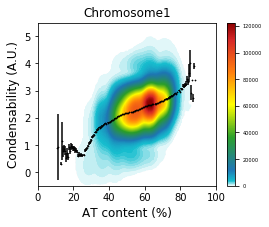

In [24]:
### [Extended Data Fig.5a]
ID_score = dkey_ID_value[target]
for feature in features:
    ID_var = dkey_ID_value[feature]

    X, Y = [], []
    var_scores = {}
    for ID, var in ID_var.items():
        var = var*100
        score = ID_score[ID]
        X.append(var)
        Y.append(score)

        if var not in var_scores:
            var_scores[var] = []
        var_scores[var].append(score)

    X_dot, Y_dot, Z_dot = [], [], []
    for var, scores in var_scores.items():
        X_dot.append(var)
        Y_dot.append(np.mean(scores))
        Z_dot.append(np.std(scores)/np.sqrt(len(scores)))

    print 'Spearman corr: %f' % (scipy.stats.spearmanr(X, Y)[0]) 

    fig, ax = plt.subplots(nrows=1,
                           ncols=1,
                           figsize=(4,3))

    graphics.density_scatter(X, Y,
                             ax=ax)
    #ax.plot(X, Y, 'k.', alpha=0.01)
    ax.plot(X_dot, Y_dot, 'k.', markersize=1)
    ax.errorbar(X_dot, Y_dot, yerr=Z_dot, fmt='.', color='k', markersize=1)
    ax.set_xlim([0, 100])
    ax.set_ylim([-0.5, 5.5])
    ax.set_ylabel('Condensability (A.U.)', fontsize=12)
    ax.set_xlabel('AT content (%)', fontsize=12)
    ax.set_title('Chromosome1', fontsize=12)
    plt.savefig('./data/' + 'var_corr_%s.png' % (feature),
                dpi=500,
                bbox_inches='tight')
    plt.show()
    plt.close()
    
        
    